This notebook is for development! Use it to try out new strategies :) 

<div class="alert alert-block alert-info">
<b>Imports:</b> Common imports for NumPy, MatplotLib, Pandas, and OS </div>

In [14]:
## Import for data generation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle

<div class="alert alert-block alert-info">
<b>ML Imports:</b> Imports to execute RNN model for sequential data </div>

In [23]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from pyspark import SparkContext
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

<div class="alert alert-block alert-warning">
<b>nn_train_test() function:</b> 
    
This function takes inputs:
    
    path --> path to the repository with all your .npy file
    n_future --> number of future days of fire you want to predict (will be 1 for us)
    n_comp --> number of principal componenents you want PCA to reduce to
    n_past --> number of past days you want to consider (we can experiment with this)
    
Outputs:
    
    input_dim is set to a 1-D array of 256 ^ 2 for now! 
    x_train --> x_train in format (batch_size, timesteps, input_dim)
    y_train --> training data in format (batch_size, input_dim)
    pca_array --> an array of all of the PCA's done to the x_training data in a row. This is useful when computing the 
    inverse of the results of your neural net!
    
</div>

In [318]:
def nn_train_test(path, n_past, n_comp, n_future = 1):
    x_train_list = []
    y_train_list = []
    count = 0
    pca_array = []
    for file in os.listdir(r"{path}".format(path = path)):
        if os.path.getsize("{path}\\{file}".format(path = path, file = file)) < 10000000:
            continue
        with open("{path}\\{file}".format(path = path, file = file), 'rb') as f:
            data = pickle.load(f)
        training_fire = data['multiDay']
        elevation_data = data['Elevation Data'][:-1,:-1]
        elev_shape = np.array(elevation_data.shape)
        elevation_fire = np.zeros((256, 256))
        shape = np.array(training_fire.shape) 
        if shape[0] < n_past + n_future:
            continue
        standard_fire = np.zeros((len(training_fire), 256, 256))    
        if shape[1] > 255 or shape[2] > 255:
            standard_fire[:shape[0], :min(256, shape[1]), :min(256, shape[2])] = training_fire[:, :256, :256]           
        else: 
            standard_fire[:shape[0], :shape[1], :shape[2]] = training_fire     
            
        if elev_shape[0] > 255 or elev_shape[1] > 255:
            elevation_fire[:min(256, elev_shape[0]), :min(256, elev_shape[1])] = elevation_data[:256, :256]
        else:
            elevation_fire[:min(256, elev_shape[0]), :min(256, elev_shape[1])] = elevation_data
        n_comp = 5
        shape = standard_fire.shape
        pca_fire = np.zeros((shape[0], shape[1], n_comp))
        j = 0
        pca_dict = {}
        for day in standard_fire:
            pca = decomposition.PCA(n_components=n_comp)
            #plt.matshow(day)
            #np.random.seed(134)           
            day = pca.fit_transform(day)                       
            #plt.matshow(day)            
            #print('------')            
            #np.random.seed(134)            
            pca_fire[j] = day
            pca_dict[j] = pca
            j += 1
        
        pca_elevation = decomposition.PCA(n_components = n_comp)
        pca_elev = pca_elevation.fit_transform(elevation_fire)
        elev_shape = np.array(pca_elev.shape)
        pca_elev = np.reshape(pca_elev, (elev_shape[0] * elev_shape[1]))
        
        shape = pca_fire.shape    
        pca_fire = np.reshape(pca_fire, (shape[0], shape[1] * shape[2]))
        x_train = np.zeros((n_past, pca_fire.shape[1]))
        y_train = np.zeros((pca_fire.shape[1]))
        for i in range(0 , len(pca_fire) - n_future - n_past + 1):
            #print("Adding {i} to {inpast}".format(i = str(i), inpast = str(i + n_past)))
            prev_fires_and_elevation = np.vstack((pca_fire[i : i + n_past], pca_elev))
            x_train_list.append(prev_fires_and_elevation)
            #print("{inpast}".format(inpast = str(i + n_past)))
            y_train_list.append(pca_fire[i + n_past: i + n_past + n_future])
            pca_array.append(pca_dict[i + n_past])
        print(data['fireID'])
        print(len(x_train_list), len(y_train_list), len(pca_array))
    x_train = np.array(x_train_list)
    y_train = np.array(y_train_list)  
    
    x_train = np.reshape(x_train, (x_train.shape[0],  x_train.shape[2], x_train.shape[1]))
    y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[2]))    
    print(x_train.shape, y_train.shape, len(pca_array))
    return x_train, y_train, pca_array

------


C:\Users\nicoc\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


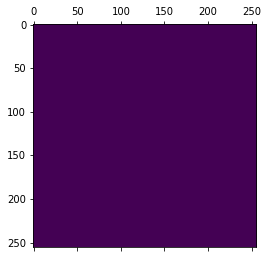

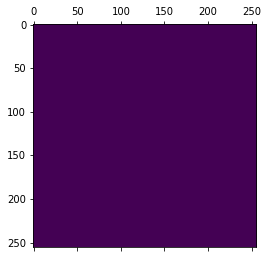

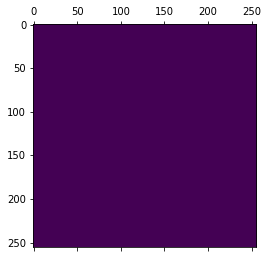

------


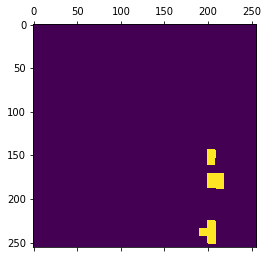

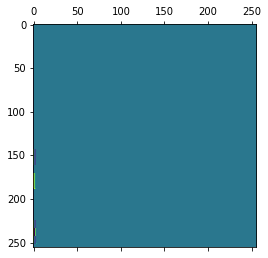

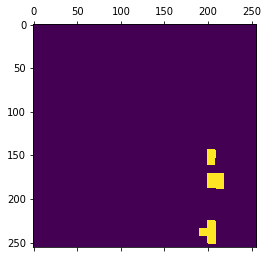

------


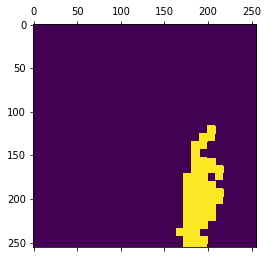

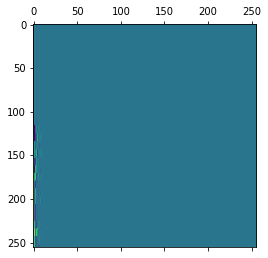

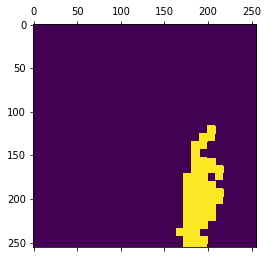

------


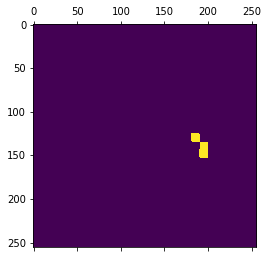

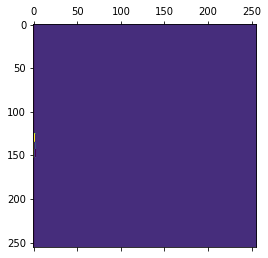

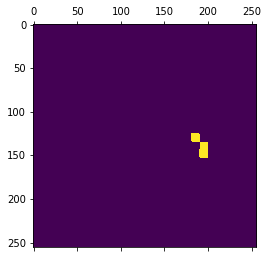

------


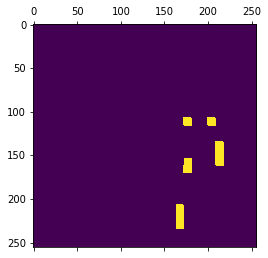

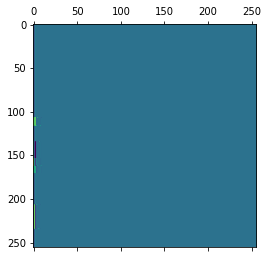

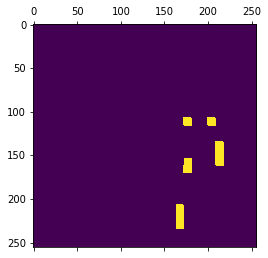

------


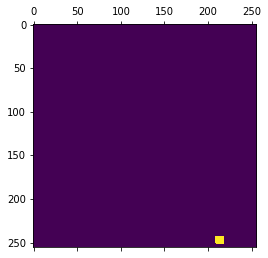

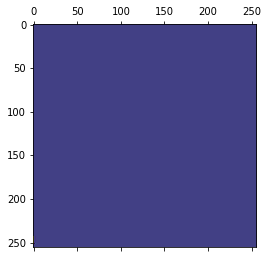

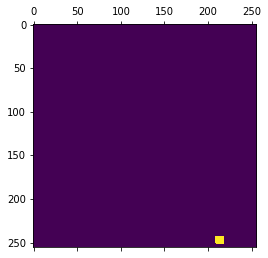

------


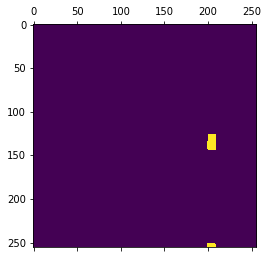

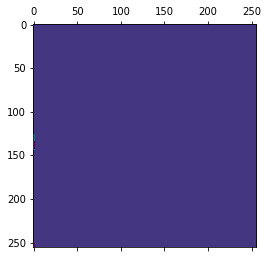

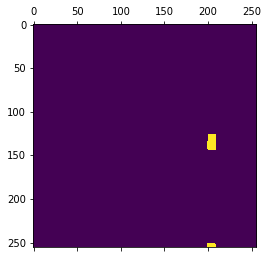

------


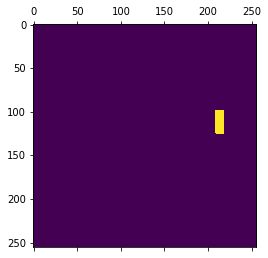

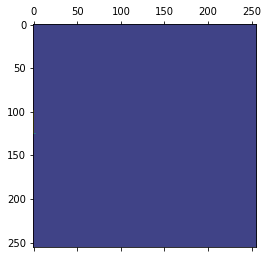

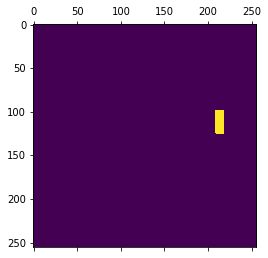

------


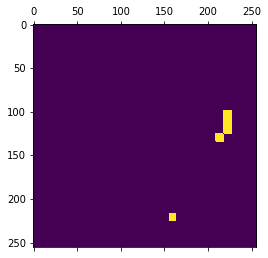

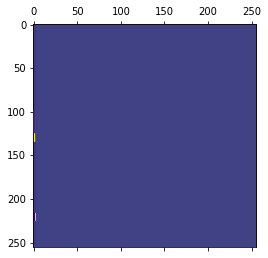

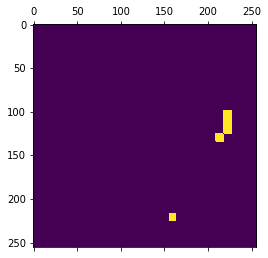

------


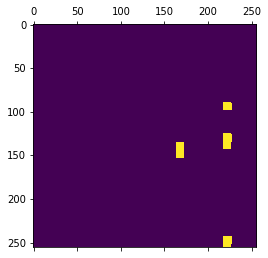

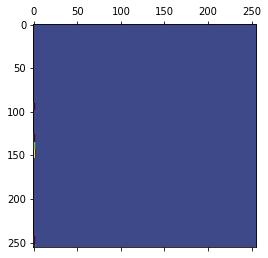

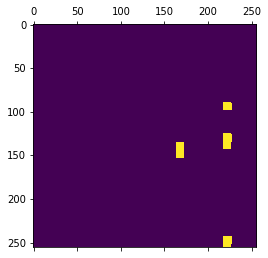

------


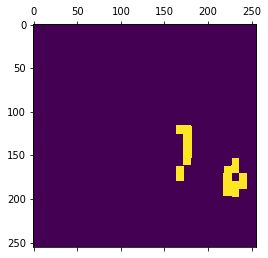

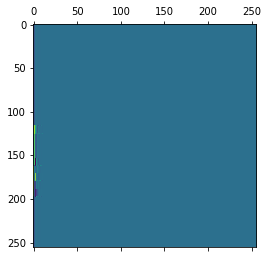

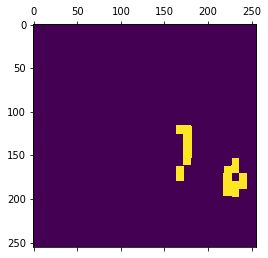

------


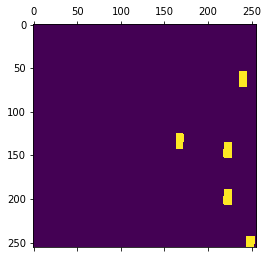

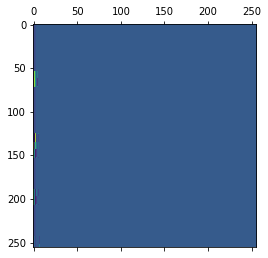

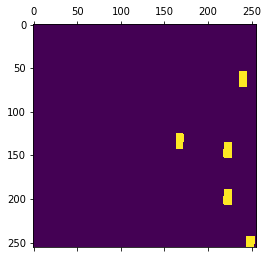

------


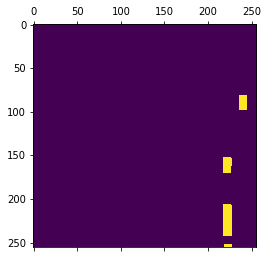

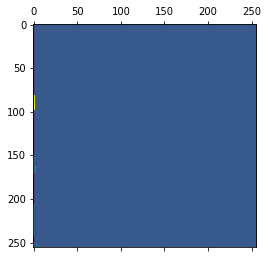

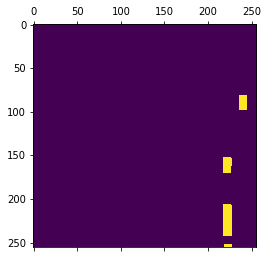

------


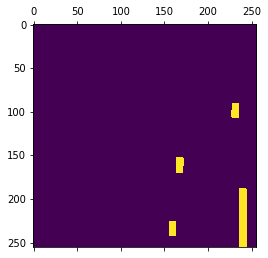

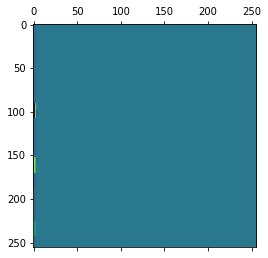

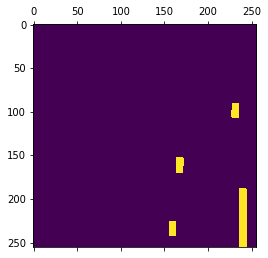

------


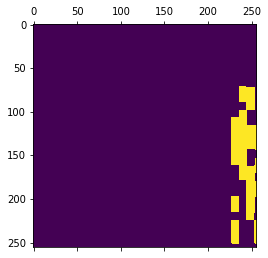

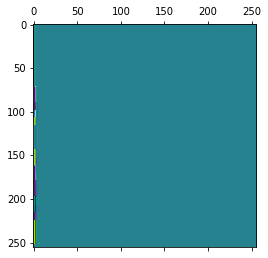

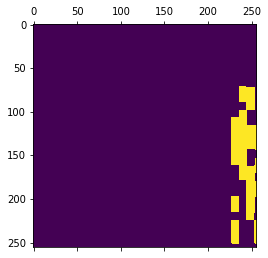

------


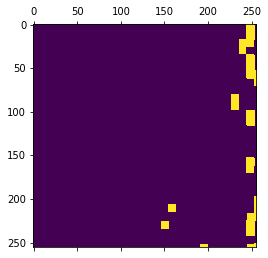

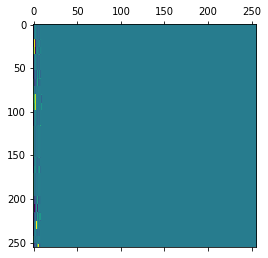

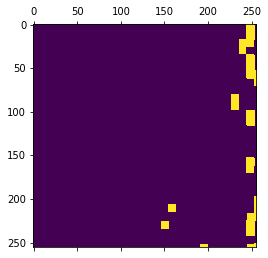

------


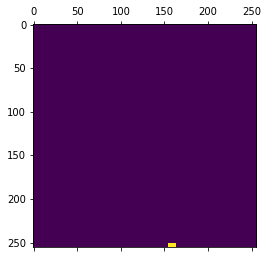

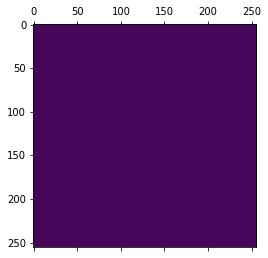

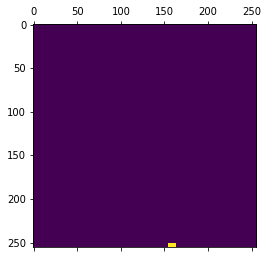

------


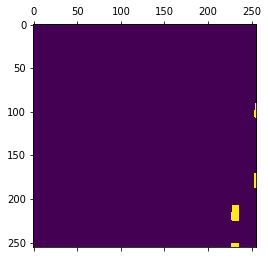

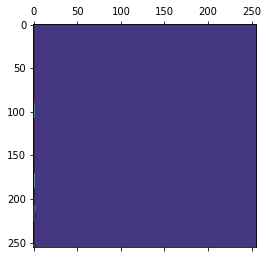

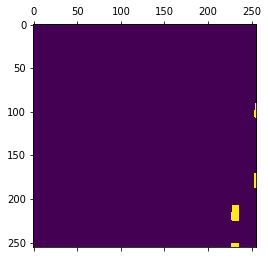

------


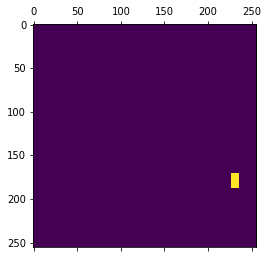

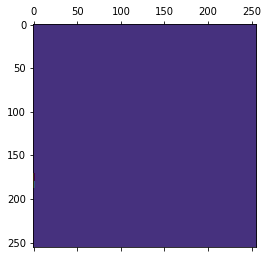

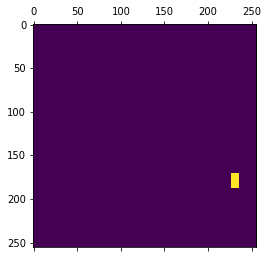

------


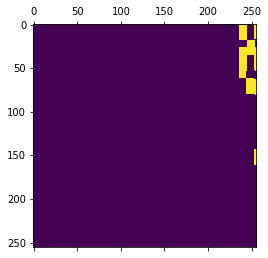

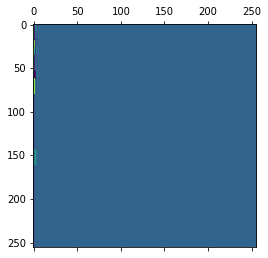

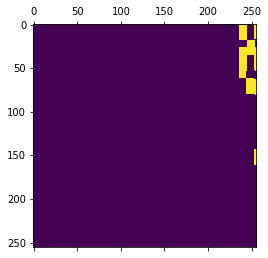

------


C:\Users\nicoc\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


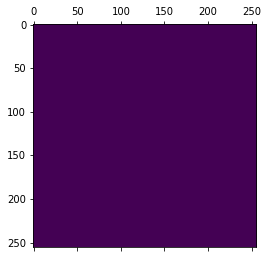

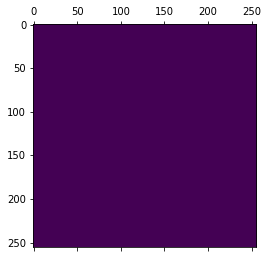

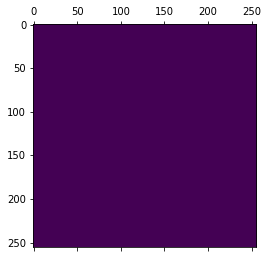

------


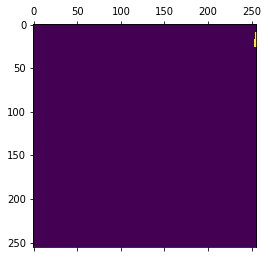

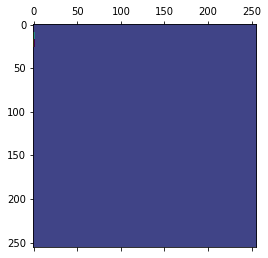

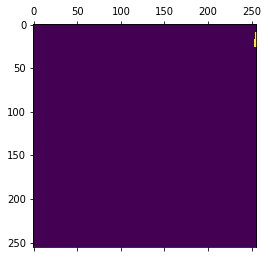

------


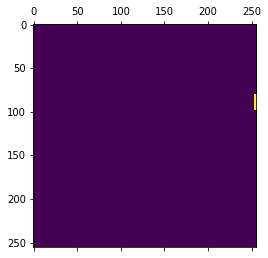

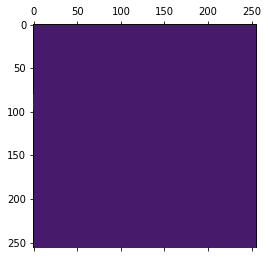

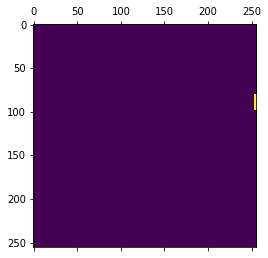

------


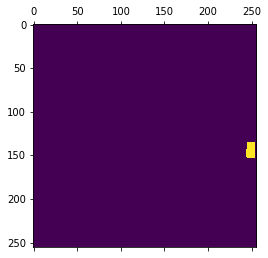

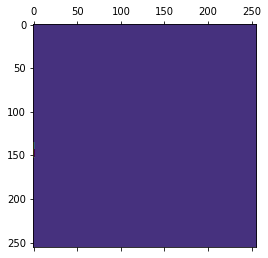

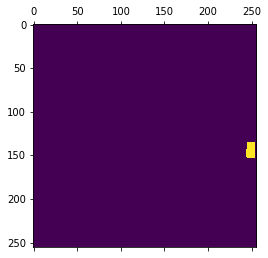

------


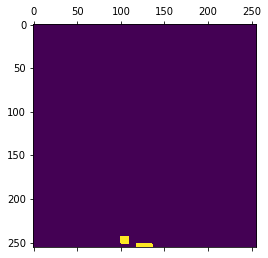

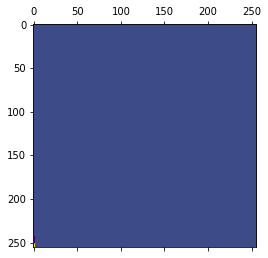

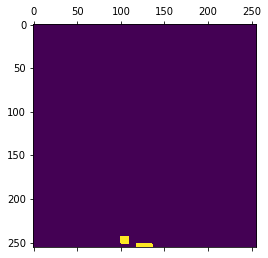

------


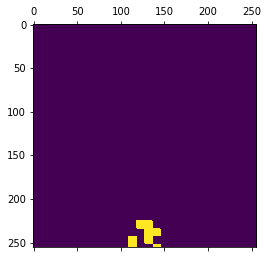

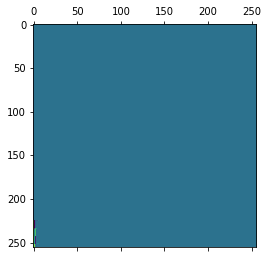

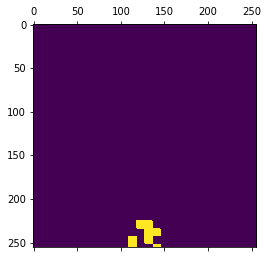

------


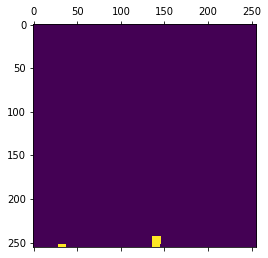

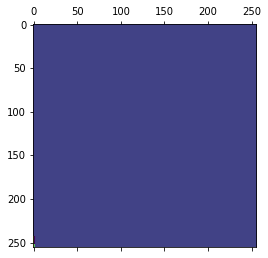

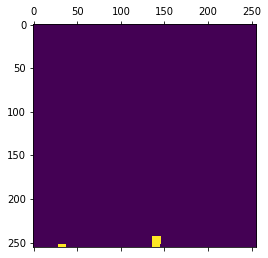

------


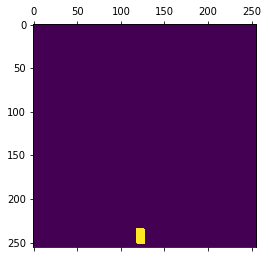

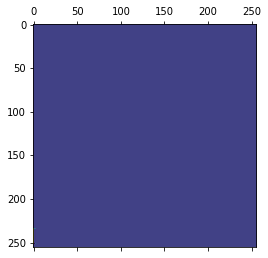

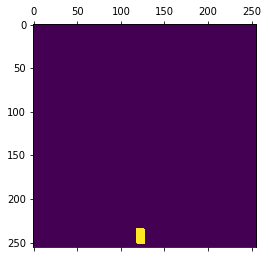

------


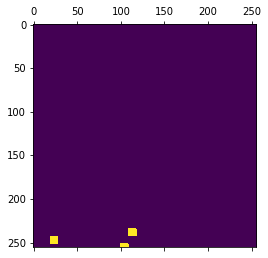

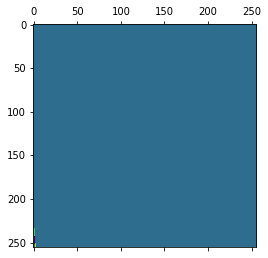

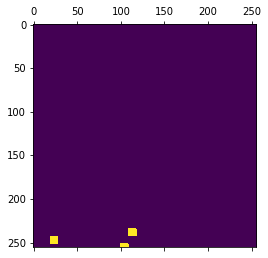

------


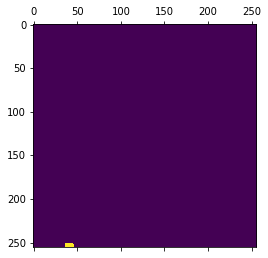

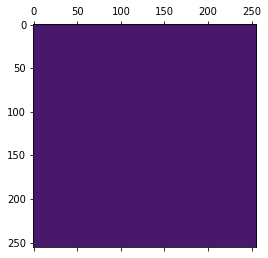

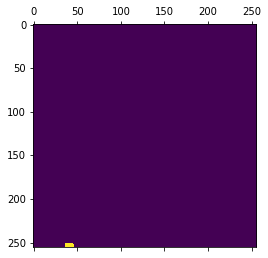

------


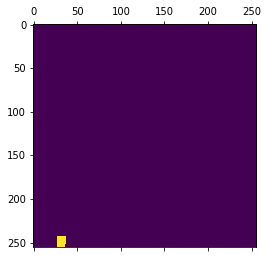

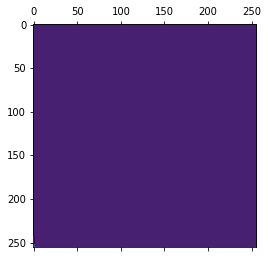

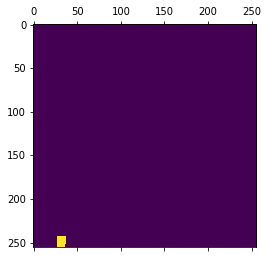

------


C:\Users\nicoc\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


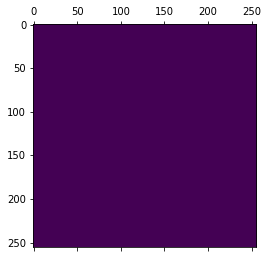

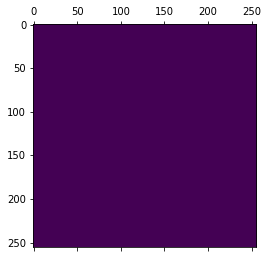

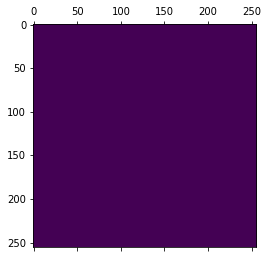

------


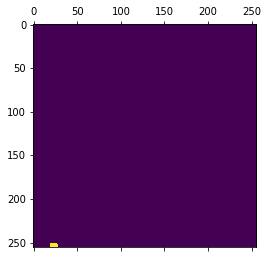

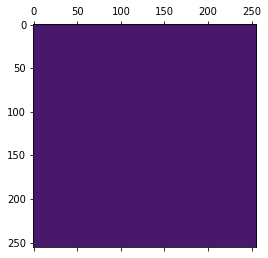

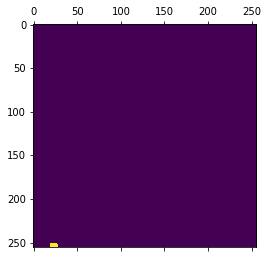

------


C:\Users\nicoc\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


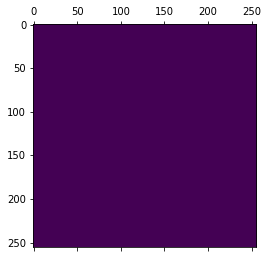

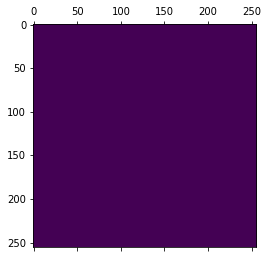

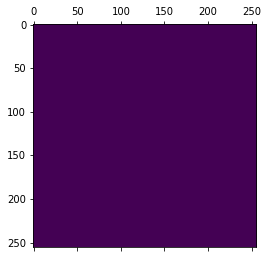

------


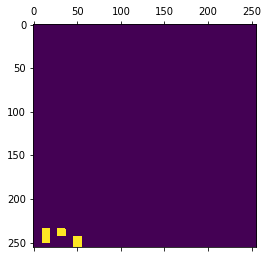

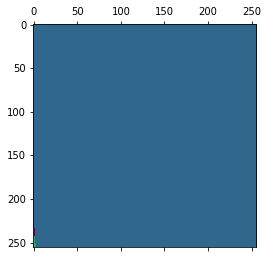

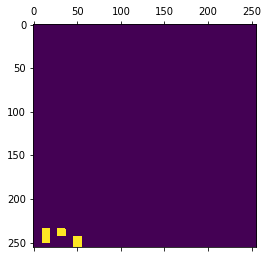

------


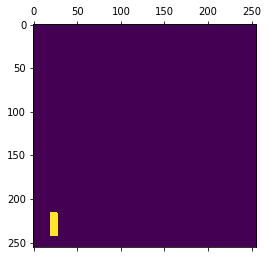

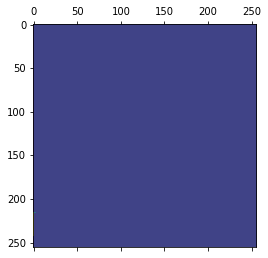

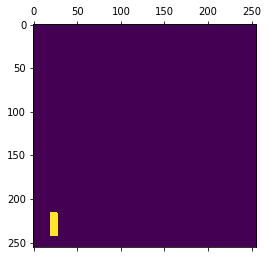

------


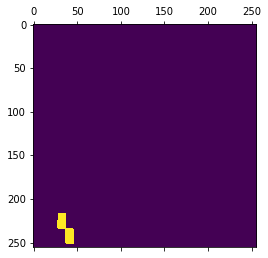

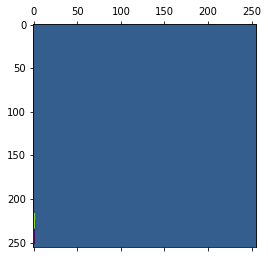

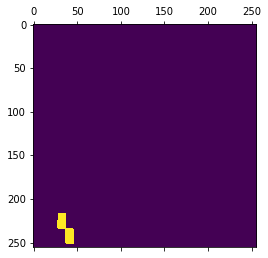

------


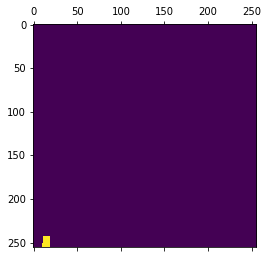

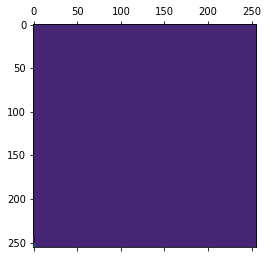

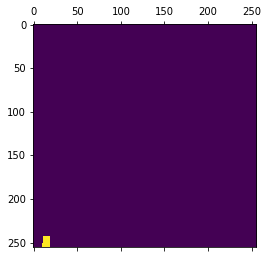

------


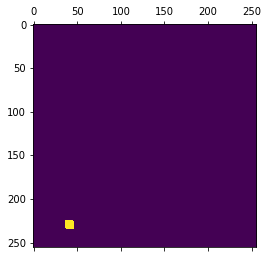

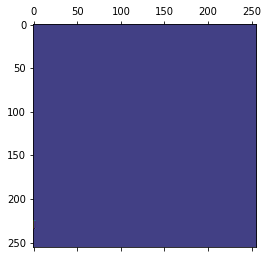

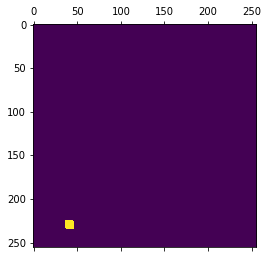

------


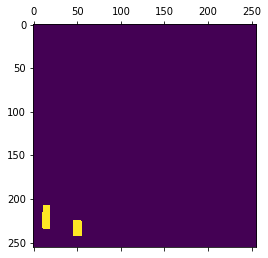

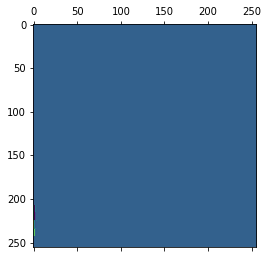

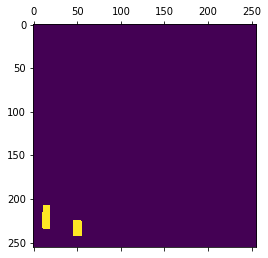

------


C:\Users\nicoc\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


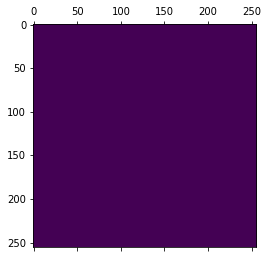

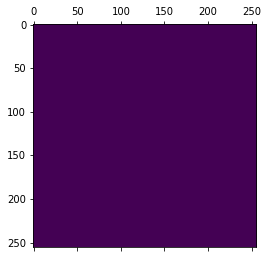

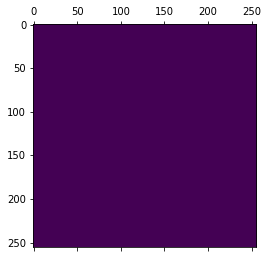

------


C:\Users\nicoc\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


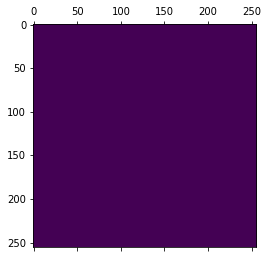

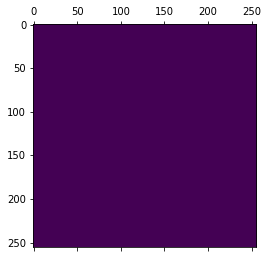

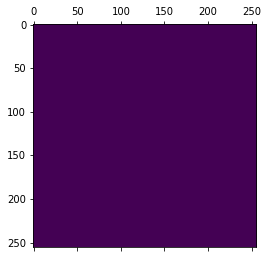

------


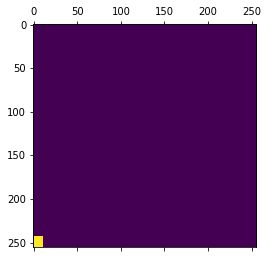

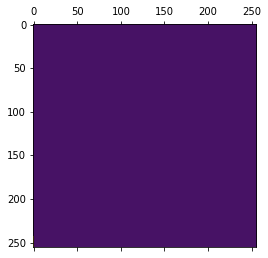

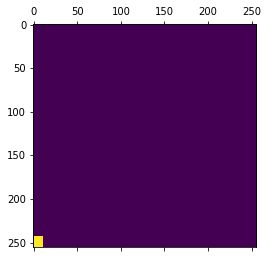

------


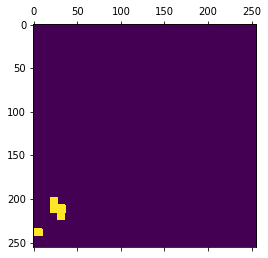

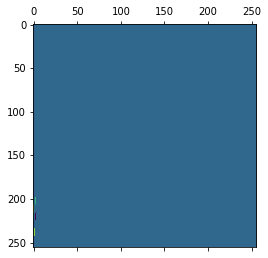

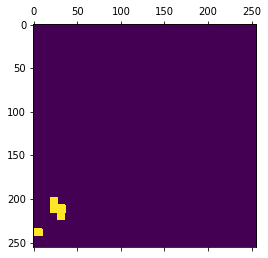

In [129]:
path = "C:\\Users\\nicoc\\Desktop\\Stanford\\OneDrive\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\data\\United_States_Fires\\United_States_2018_Fires\\dec\\storage"  
file = '21121280.pkl' 
n_comp = 256
with open("{path}\\{file}".format(path = path, file = file), 'rb') as f:
    data = pickle.load(f)
training_fire = data['multiDay']
shape = np.array(training_fire.shape) 
standard_fire = np.zeros((len(training_fire), 256, 256))    
if shape[1] > 255 or shape[2] > 255:
    standard_fire[:shape[0], :min(256, shape[1]), :min(256, shape[2])] = training_fire[:, :256, :256]           
else: 
    standard_fire[:shape[0], :shape[1], :shape[2]] = training_fire     
shape = standard_fire.shape
pca_fire = np.zeros((shape[0], shape[1], n_comp))
j = 0
pca_dict = {}
for day in standard_fire:
    pca = decomposition.PCA(n_components=n_comp)
    plt.matshow(day)
    np.random.seed(134)           
    day = pca.fit_transform(day)                       
    plt.matshow(day)  
    day3 = pca.inverse_transform(day)            
    plt.matshow(day3)
    print('------')
    plt.show()
    np.random.seed(134)            
    pca_fire[j] = day   
    pca_dict[j] = pca    
    j += 1

44

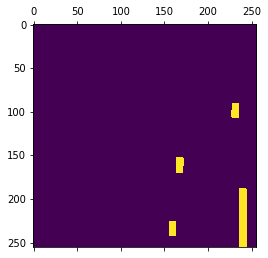

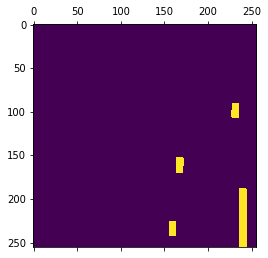

In [46]:
i = 13
plt.matshow(pca_dict[i].inverse_transform(pca_fire[i]))
plt.show()
plt.matshow(standard_fire[i])

<div class="alert alert-block alert-warning">
<b>RNN Inputs:</b> 
We are declaring below that the number of future days we want to predict is 1, and we can vary the number of past days
    we want to predict (I have the default as 3 for now)

</div>

In [51]:
n_future = 1
n_comp = 5
n_past = 3

<div class="alert alert-block alert-warning">
<b>Input Data for Training:</b> 
    Below, we get the input data from December 2018! 
</div>

In [319]:
%%capture 
# We are suppressing print statements and warning messages w/ above line
path = "C:\\Users\\nicoc\\Desktop\\Stanford\\OneDrive\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\data\\United_States_Fires\\United_States_2018_Fires\\dec\\storage"  
x_train, y_train, pca_array  = nn_train_test(path, n_past = n_past, n_comp = n_comp, n_future = n_future)
#x_train, y_train = nn_train_test2(path, n_past = n_past, n_comp = n_comp, n_future = n_future)

In [284]:
%%capture 
# We are suppressing print statements and warning messages w/ above line
path = "C:\\Users\\nicoc\\Desktop\\Stanford\\OneDrive\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\data\\United_States_Fires\\United_States_2018_Fires\\dec\\storage"  
x_train_list, y_train_list  = nn_train_test(path, n_past = n_past, n_comp = n_comp, n_future = n_future)
#x_train, y_train = nn_train_test2(path, n_past = n_past, n_comp = n_comp, n_future = n_future)

Adding 0 to 3 \
3 \
Adding 1 to 4 \
4 \
Adding 2 to 5 \
5

<div class="alert alert-block alert-warning">
<b>Check:</b> 
    Check the shape of your x_train and y_train data
</div>

In [55]:
y_train.shape, x_train.shape

((408, 1280), (408, 1280, 4))

<div class="alert alert-block alert-success">
<b>Train your RNN:</b> Train your RNN using the training data.
    
    You might notice a lot of arbitrary values here (these are things we will want to change and test)
    - Dropout: High dropout leads to more generalization. Low dropout takes advantage of more data but overfits more easily
    - # of hidden layers: Right now, there are 2 hidden layers (+ 1 at the end). We can change this
    - # units at hidden layers: Right now, units decrease by 1 at each hidden layer. This is arbitrary and can be changed
    - optimizer --> 'adam' works but I don't know what it does
    - epochs --> We can raise this above 1 but I don't notice that changing much when I have done so
    - batch_size --> Higher batch size leads to more generalization
</div>

In [56]:
# No need to run this if you are loading a model
regressor = Sequential()

dropout = 0.1
regressor.add(tf.keras.layers.Bidirectional(LSTM(units=n_past, return_sequences=True, input_shape = x_train[0].shape)))
regressor.add(Dropout(dropout))

regressor.add(LSTM(units = n_past-1, return_sequences = True))
regressor.add(Dropout(dropout))

'''
regressor.add(LSTM(units = n_past-2, return_sequences = False))
regressor.add(Dropout(dropout))
'''
'''
regressor.add(LSTM(units = n_past, return_sequences = True))
regressor.add(Dropout(dropout))
'''

regressor.add(Dense(units = n_future, activation = 'linear'))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['acc'])

regressor.fit(x_train, y_train, epochs = 1, batch_size = 3)

136/136 [==============================] - 92s 621ms/step - loss: 0.7677 - acc: 0.1571


<div class="alert alert-block alert-warning">
<b>Load pre-trained model:</b> 
    If you want to load a model instead, use this
</div>

In [ ]:
from keras.models import load_model
model_name = 'my_model_no_scalar' ## CHANGE THIS (e.g. 'my_model') ##
regressor = load_model(model_name)

<div class="alert alert-block alert-warning">
<b>Save pre-trained model:</b> 
    If you want to save a model instead, use this
</div>

In [ ]:
model_name = 'elevation_model'## CHANGE THIS (e.g. 'my_model') ##
regressor.save(model_name)

<div class="alert alert-block alert-warning">
<b>Input Data for Testing:</b> 
    Below, we get the input data from March 2018! 
</div>

In [377]:
%%capture
path = path = "C:\\Users\\nicoc\\Desktop\\Stanford\\OneDrive\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\data\\United_States_Fires\\United_States_2017_Fires\\nov\\storage"
x_test, y_test, pca_array  = nn_train_test(path, n_past = 3, n_comp = n_comp, n_future =1)

<div class="alert alert-block alert-warning">
<b>Check:</b> I've noticed the first dimensions of these sometimes these don't match. They should.
</div>

In [169]:
x_test.shape, y_test.shape, len(pca_array)

((88, 1280, 4), (88, 1280), 11)

<div class="alert alert-block alert-warning">
<b> Predict Step:</b> This makes your predictions using your model and reshapes them into a list of 2D arrays
</div>

In [378]:
from sklearn.preprocessing import MinMaxScaler
#sc = MinMaxScaler(feature_range=(0,1)) This might be useful for making absolute predictions
predict_test = regressor.predict(x_test)
p = predict_test
shape = predict_test.shape
nComp = 5
predict_test = np.reshape(predict_test, (shape[0], nComp, shape[1]//nComp))

In [195]:
a = np.reshape(predict_test, (shape[0], nComp, shape[1]//nComp))

In [214]:
y_test.shape, a.shape

((88, 1280), (88, 5, 256))

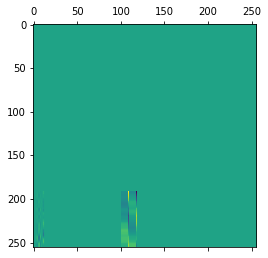

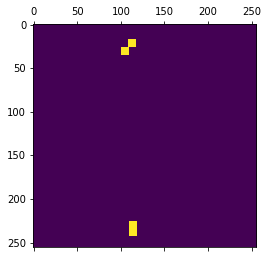

In [379]:
k = 44
b = x_test[k+1][:, 2].reshape((256, 5))
plt.matshow(pca_array[k].inverse_transform(b))
plt.matshow(pca_array[k].inverse_transform(y_test[k].reshape((256,5))))

<div class="alert alert-block alert-warning">
<b> Predict Step:</b> Change the number for test number to see how well your network is doing visually
    
    Note the pca_array[i].inverse_transform()!
</div>

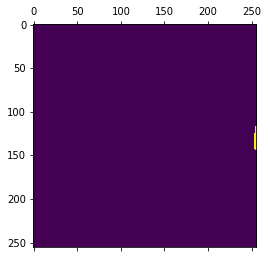

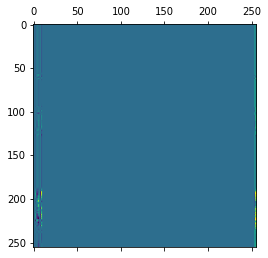

In [388]:
test_number = i = 81
d = y_test[i]
d1 = np.reshape(d, (256, 5))
plt.matshow(pca_array[i].inverse_transform(d1))
d = predict_test[i]
d = predict_test[i] * np.sum(np.abs(d1))/np.sum(np.abs(predict_test[i]))
d = np.reshape(d, (256, 5))
plt.matshow(pca_array[i].inverse_transform(d))

In [204]:
np.sum(abs(d1)), np.sum(abs(d))

(154.34656673334814, 154.34656)

In [80]:
predict_test[0:10, 0:10], y_test[0:10, 0:10]

(array([[[-0.02229184, -0.02086305, -0.02058366, ..., -0.02357488,
          -0.02357488, -0.02357488],
         [-0.02357488, -0.02357488, -0.02357488, ..., -0.02357488,
          -0.02357488, -0.02357488],
         [-0.02357488, -0.02357488, -0.02357488, ..., -0.02357488,
          -0.02357488, -0.02357488],
         ...,
         [-0.02358929, -0.02359071, -0.02359227, ...,  0.04444155,
          -0.01019296, -0.00348775],
         [ 0.09393125,  0.07247174,  0.04557582, ...,  0.09372862,
           0.01768242, -0.01823974],
         [ 0.01311636,  0.0696037 ,  0.07590911, ...,  0.08279523,
          -0.0811611 , -0.1443742 ]],
 
        [[-0.02229184, -0.02086305, -0.02058366, ..., -0.02357488,
          -0.02357488, -0.02357488],
         [-0.02357488, -0.02357488, -0.02357488, ..., -0.02357488,
          -0.02357488, -0.02357488],
         [-0.02357488, -0.02357488, -0.02357488, ..., -0.02357488,
          -0.02357488, -0.02357488],
         ...,
         [-0.02358929, -0.0235907

In [84]:
predict_test_i = np.reshape(predict_test[1], (256, 5))

In [123]:
y.size

1280

In [124]:
np.sum(np.sign(y) == np.sign(p))/y.size

0.5078125

In [125]:
i = 40
d = y_test[i]
y = np.reshape(d, (256, 5))
d = predict_test[i]
p = np.reshape(d, (256, 5))

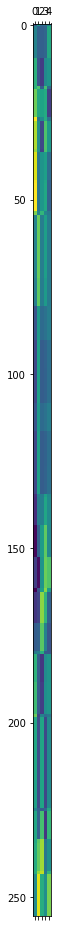

In [126]:
plt.matshow(y)

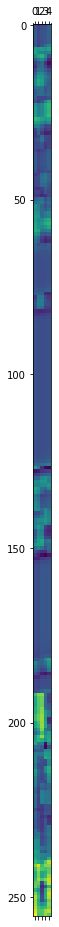

In [127]:
plt.matshow(p)